# Custom Environment: Intermediate Haunted Mansion
------

Building on top of the simple environment by adding in ghosts and candies, in addition to a penalty for each timestep the agent is not at its target location.

Rules of the environemnt are the same with some modifications:

    - There are 4 discrete actions the agent can take: up. down, left and right
    - The game terminates when the agent has reached the exit door of the haunted mansion
    - The agent represents the trick-or-treater
    - The agent receives a reward of + 10 when they have reached the exit door
    - For each timestep where the agent is not at the target location, they receive a penalty of - 0.1
    - If the agent encounters a ghost along their path they receive a penalty of -5, if they encounter a candy they recieve reward of +5

## Set Up
-----

In [1]:
import numpy as np
import gymnasium as gym
import pygame
import sys
import matplotlib.pyplot as plt
from intermediate_env import Intm_Haunted_Mansion

## Defining Custom Environment
----

In [2]:
# Register the environment
gym.register(
    id='Haunted_Mansion-v2',
    entry_point = 'intermediate_env:Intm_Haunted_Mansion'  
)

In [3]:
# Make the custom env, set the render_mode to huamn
env = gym.make('Haunted_Mansion-v2',  render_mode='human')

### Quick Rendering Test with Random Actions

In [4]:
# Resetting the environment, to set the agent to a random starting place on the grid
env.reset()
score = 0
# Run the environment for 50 random steps
for i in range(50):

    # Using sample() to pick random action for agent to take
    action = env.action_space.sample()
    # Calling step to get information on env after action takes the random action
    obs, reward, terminated, truncated, info = env.step(action)

    env.render()
    
    # Add time delay in pygame to pause after each action, allows for better viewing
    pygame.time.delay(350)
    score =+ reward

    # If the agent has reached the target, break out of the loop and end the episode
    if terminated:
        break

# Close the environment
env.close()

## Training with PPO
---

In [5]:
# Importing stable baselines 3 for PPO and Wrappers
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.vec_env import VecMonitor

In [6]:
log_path = ('../../Training/Logs/')

In [7]:
# Create the environment and vectorise it using DummyVecEnv
v_env = DummyVecEnv([lambda: gym.make('Haunted_Mansion-v2', render_mode = None) for i in range(3)])
# Using VecMonitor since have multiple environments
learn_env = VecMonitor(v_env,filename=log_path) 

In [8]:
# Initialise PPO model
# Having to use MultiInputPolicy instead of MlpPolicy since observations are of type dict
model = PPO('MultiInputPolicy', learn_env, verbose=1)

# Train the agent for 100_000 time steps
model.learn(total_timesteps=100_000)

Using cpu device


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 73.7     |
|    ep_rew_mean     | -23.6    |
| time/              |          |
|    fps             | 10099    |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 6144     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 35.3        |
|    ep_rew_mean          | -1.58       |
| time/                   |             |
|    fps                  | 5372        |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 12288       |
| train/                  |             |
|    approx_kl            | 0.018951708 |
|    clip_fraction        | 0.292       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.37       |
|    explained_variance   | -0.00334    |
|    learning_rate        | 0.

### Training Logs and Graphs

In [9]:
# Path to monitor.csv file
monitor_file = ('../../Training/Logs/monitor.csv') 

In [10]:
import pandas as pd
# Read the CSV file using pandas
df = pd.read_csv(monitor_file,skiprows=1)

In [11]:
episode_rewards = df['r'].values  # 'r' column contains the reward per episode
episode_lengths = df['l'].values  # 'l' column contains the length of each episode
episode_time = df['t'].values 

In [12]:
# Using moving average to smooth out the noise in both rewards and episode length
smoothed_rewards = pd.Series(episode_rewards).rolling(window=100).mean()
smoothed_length = pd.Series(episode_lengths).rolling(window=100).mean()

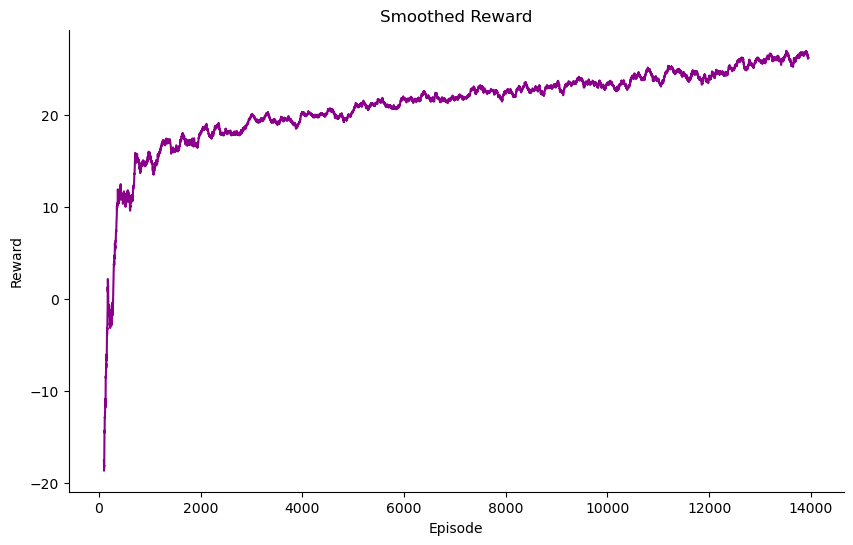

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(smoothed_rewards, color='darkmagenta')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Smoothed Reward')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()

----
**Comment:**

Early in the training, the reward for the first 2000 episdoes vary a lot. This makes sense as this is when the agent is exploring the environment, updating its policy based on its observations. This can be seen by the steep improvement in reward per episode as the policy is updated and the agent starts to exploit the environemnt.

After 2000 episodes, the curve begins to flatten and the rewards start to stabalise around the 20 mark. This is a sign the agent has successfully learned the task well enough and its performance is now stable. After 8000 episodes, the agent's performance no longer improves much suggesting the agent has reached a near optimal policy.

Overall training the agent aligned with typical patterns seen from RL agents. The agent gradually shifts from exploration to exploitation with the learning curve flattening as it reaches a near-optimal policy. 

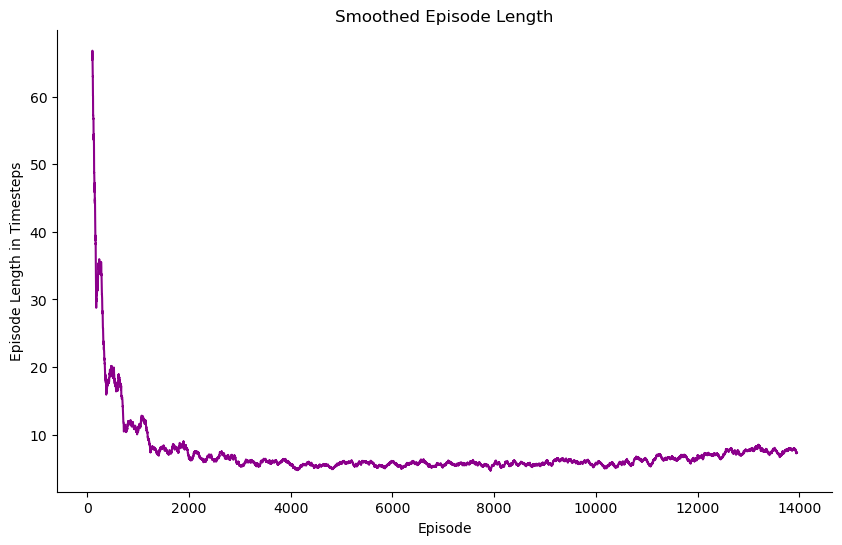

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(smoothed_length, color='darkmagenta')
plt.xlabel('Episode')
plt.ylabel('Episode Length in Timesteps')
plt.title('Smoothed Episode Length')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()

-----
**Comment:**

Early in the training the agent takes a more timesteps to complete the task. This makes sense in RL as early on in the training the agent prioritises exploring its environment taking more timesteps.

As the training progresses, the agent refines its policy and begins to exploit what it has learned, leading to fewer timesteps per episode. The curve beigns to plateau around episode 4000, the agent's policy has become more effective in completing the task, This stability in timesteps suggests the agent has learned a near-optimal path.

After 14,000 episodes, there is a slight increase in timesteps. I am unsure why this could be happening, perhaps the agent has begun to overfit to the certain environment states and struggles in different states. This would be something to look into, I think I will have to do a bit more research into RL to see why this


### Saving the Model

In [15]:
model.save('../../Training/Saved Models/PPO_intm_haunted_mansion')

### Evaluation

In [16]:
from stable_baselines3.common.evaluation import evaluate_policy
evaluate_policy(model, learn_env, n_eval_episodes = 10, render = False)

(28.61, 1.5436642)

----
**Comment**

**Mean Reward: 26.34**
- Average reward across all ten episodes is greater than 20.
- 20 points is given when the agent reaches the target(door), this means the agent has learned the task successfully.

**Standard Deviation: 4.21**
- Shows some variability in the agent's performance across all episodes.
- Suggests the policy the agent has is rather stable and produces consistent results.- Could be as penalty for a action not resulting in reward is too low at -0.1 could increase to -0.2 but then also would reduce the exploration of the agent.

### Testing After Training

In [17]:
env = gym.make('Haunted_Mansion-v2', render_mode = 'human', step_penalty = 0.2)

In [18]:
# Setting the number of episodes for testing
episodes = 15

for episode in range(1, episodes + 1):
   
    # Resetting the environment to an initial state
    obs, info_= env.reset()
    done = False
    score = 0
    
    while not done:
        # Get action from the trained model
        action, _ = model.predict(obs) 
        # Step through the environment using the action
        obs, reward, terminated,truncated, info = env.step(action)  
               
        # Update the done condition based on terminated flag (truncated is always False in this env)
        done = terminated

        # Visualise the environment after each action agent takes
        env.render()

        # Add reward received for action to total episode score
        score += reward
        
        # Delay to slow down the movement for better observation
        pygame.time.delay(350) 
    
    # After the episode ends, print the score
    print(f'Episode {episode} Score: {round(score,2)}')

env.close()

Episode 1 Score: 19.2
Episode 2 Score: 28.2
Episode 3 Score: 28.6
Episode 4 Score: 28.0
Episode 5 Score: 28.4
Episode 6 Score: 28.0
Episode 7 Score: 28.0
Episode 8 Score: 28.0
Episode 9 Score: 28.4
Episode 10 Score: 28.4
Episode 11 Score: 28.4
Episode 12 Score: 28.4
Episode 13 Score: 23.0
Episode 14 Score: 19.8
Episode 15 Score: 27.6


-----
**Comment:**

Overall the agent shows a strong performance all but one score are greater than or equal to 20. 

Training with PPO was sufficient in this instance, could be due to the relative simplicity of the environment still. All objects (rewads/penalites) in the environemnt are stable apart from the agent. I now progress to training with Q-learning to compare results. 

I could also experiment more in fine tuning the rewards, especially the reward for taking unnecessary steps. Therefore I decided to add the penalty per step as a input paramter on environment init. This makes it easier to experiment with.

## Training with Q-learning
----

    Steps to Implement Q-Learning:
    Step 1: Define the environment (state space, action space, reward function).
    Step 2: Initialize the Q-table.
    Step 3: Implement the agent's exploration/exploitation strategy (ε-greedy).
    Step 4: Implement the Q-update rule.
    Step 5: Train the agent by letting it interact with the environment and update the Q-table.
    Step 6: After training, the Q-table will contain the optimal policy.


## Summary
---

### RL Task Outline